In [1]:
%matplotlib inline
import tensorflow as tf
import dirt
import cv2
import menpo3d.io as m3io
import pickle
import numpy as np

from scipy.io import loadmat
from menpo.image import Image
from menpo.shape import PointCloud, TriMesh
from copy import deepcopy
from os.path import join, split


def ProjectShape(vertex, fR, T, roi_bbox):
    # function in pytorch 3DDFA
    STD_SIZE = 120
    
    # transform to image coordinate scale
    vertex = fR.dot(vertex) + T
    vertex[1,:] = STD_SIZE + 1 - vertex[1,:]
    
    sx, sy, ex, ey = roi_bbox
    scale_x = (ex - sx) / STD_SIZE
    scale_y = (ey - sy) / STD_SIZE
    vertex[0, :] = vertex[0, :] * scale_x + sx
    vertex[1, :] = vertex[1, :] * scale_y + sy

    s = (scale_x + scale_y) / 2
    vertex[2, :] *= s
    
    return vertex

In [109]:
from menpo.shape import TriMesh, ColouredTriMesh, TexturedTriMesh
from scipy.spatial import cKDTree


def delete_trimesh_points(keep_list, mesh):
    """
    Delete points in the TriMesh, according to the keep_list.
    Copy the landmarks, texture (for TextureTriMesh) as well.

    Parameters
    ----------
    keep_list : 'boolean array'
        list to store delete status, 'False' means to delete.

    mesh : 'TriMesh'
        source mesh.

    Return:
    ---------
    A new TriMesh (or TextureTriMesh, ColouredTriMesh) and the index correspondence between new and old vertices
    """
    pts = mesh.points
    tri = mesh.trilist

    if len(keep_list) != pts.shape[0]:
        raise ValueError('keep_list has different size to points!')

    # set the keep index of triangles based on the vertex status
    keep_tri = np.all(keep_list[tri], axis=1)

    # create the correspondence table between new and old index
    v_index = np.where(keep_list)[0]
    new_v_index = np.array(range(v_index.size), dtype=v_index.dtype)
    v_corr = dict(zip(v_index, new_v_index))

    new_pts = pts[keep_list, :]
    old_tri = tri[keep_tri, :]
    # replace the old index
    new_tri = np.array([[v_corr[idx] for idx in tmp] for tmp in old_tri], dtype=old_tri.dtype)

    if type(mesh) == TriMesh:
        new_mesh = TriMesh(new_pts, trilist=new_tri)
    elif type(mesh) == ColouredTriMesh:
        new_colours = mesh.colours[keep_list, :]
        new_mesh = ColouredTriMesh(new_pts, trilist=new_tri, colours=new_colours)
    elif type(mesh) == TexturedTriMesh:
        new_tcoords = mesh.tcoords.points[keep_list, :]
        new_mesh = TexturedTriMesh(new_pts, new_tcoords, mesh.texture, trilist=new_tri)
    else:
        raise TypeError('Unknown class: {}'.format(type(mesh)))

    # copy the landmarks as well
    for key in mesh.landmarks.keys():
        new_mesh.landmarks[key] = mesh.landmarks[key].copy()

    return new_mesh, v_corr

In [110]:
m_face_tri = loadmat('Model_face_tri.mat')
tri = deepcopy(m_face_tri['tri'] - 1).T

tri = tri[:,::-1]

image_file = 'example_image_02.jpg'
image = cv2.imread(image_file)
canvas_height, canvas_width, _ = image.shape

result_file = 'example_image_02.pkl'
with open(result_file, 'rb') as f:
    data = pickle.load(f, encoding='latin1')

In [111]:
template_path = '/home/SERILOCAL/shiyang.c/Projects/3D/face_reconstruction_GCN/coma/data/face_parts_basel09'
template_mesh = m3io.import_mesh(join(template_path, 'basel09_mean.obj'))

with open(join(template_path, 'face_segmentation_mask.pkl'), 'rb') as f:
    face_segmentation_mask = pickle.load(f)
mask_annotation = face_segmentation_mask['mask_annotation']

# get color definition from mask annotation
colours = np.stack(list(face_segmentation_mask['rgb_index2color'].values()))

# exclude some parts
parts_to_exclude = ['left_backhead_patch', 'right_backhead_patch']
keep_list = np.ones(template_mesh.n_points, dtype=np.bool)
for key in list(mask_annotation.keys()):
    if mask_annotation[key]['part_name'] in parts_to_exclude:
        keep_list[mask_annotation[key]['v_index']] = False
        mask_annotation.pop(key)        

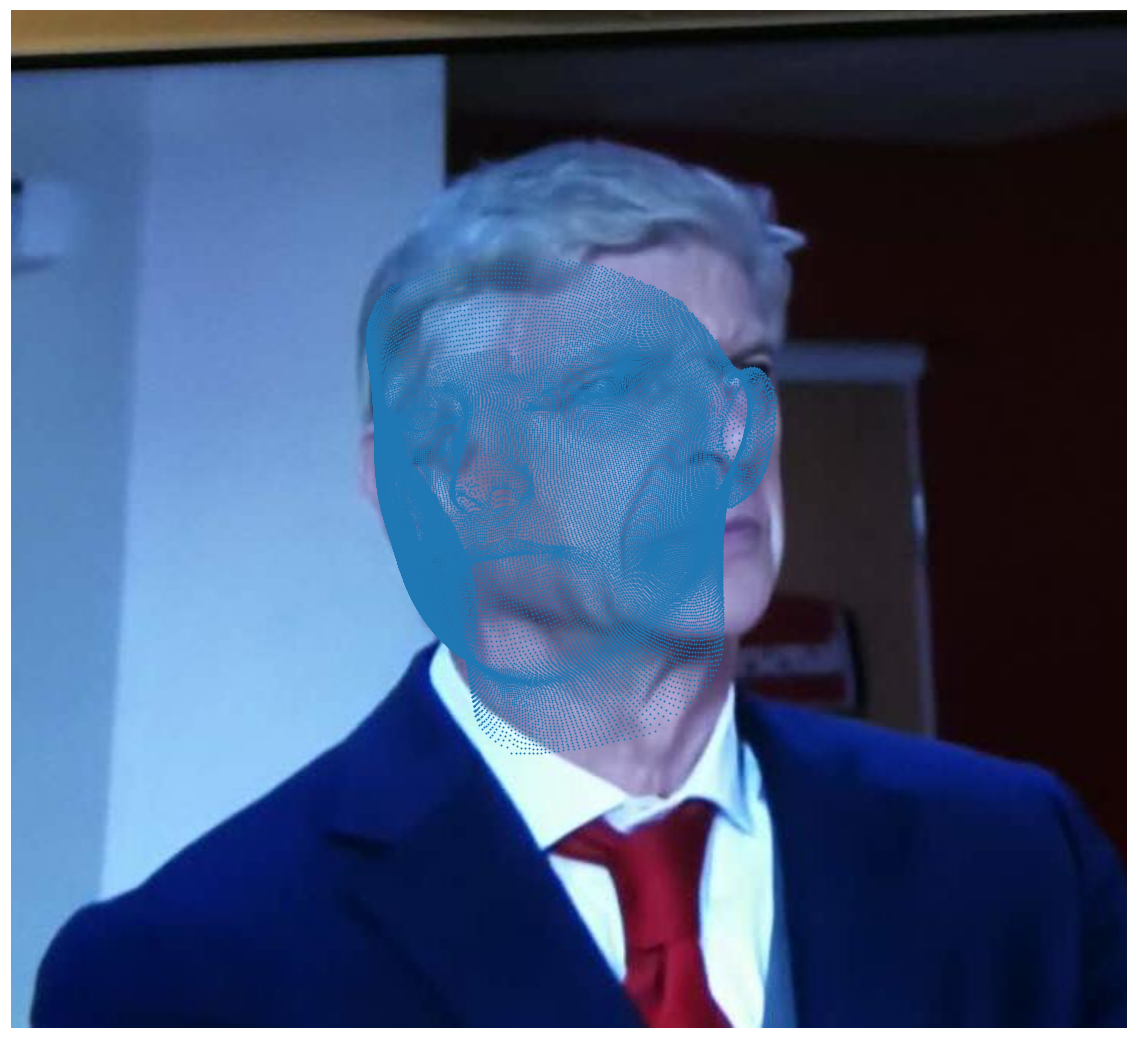

In [112]:
# extract parameters from the 3ddfa results
yaw, pitch, roll = data['face_pose']['yaw'], data['face_pose']['pitch'], data['face_pose']['roll']
vertex = data['vertex']
n_vertex = vertex.shape[1]
fR, T, roi_box = data['camera_transform']['fR'], data['camera_transform']['T'], data['roi_box']

rad = -0.9
# fR = fR.dot(np.array([[np.cos(rad), -np.sin(rad), 0], [np.sin(rad), np.cos(rad), 0], [0,0,1]]))
fR = fR.dot(np.array([[np.cos(rad), 0, np.sin(rad)], [0,1,0], [-np.sin(rad), 0, np.cos(rad)]]))

vertex_projected = ProjectShape(vertex, fR, T, roi_box)

im = Image.init_from_channels_at_back(image[:,:,::-1])
im.landmarks['vertex'] = PointCloud(vertex_projected.T[:,:2][:,::-1])
im.view_landmarks(figure_size=(20,20), marker_size=1)

In [113]:
vertex_scaled = vertex_projected.T[:,:2]
# the image coordinate system is a bit different from us.
# the origin of an image is indeed (0, image_height)
vertex_scaled[:, 1] = canvas_height-vertex_scaled[:, 1]
vertex_scaled = vertex_scaled * 2. / [canvas_width, canvas_height] - 1.
tf_vertices = tf.concat([vertex_scaled, tf.zeros([vertex_scaled.shape[0], 1]), tf.ones([vertex_scaled.shape[0], 1])], axis=1)

tf_tri = tf.constant(tri, dtype=tf.int32)

vertex_colors_full = np.zeros((vertex_scaled.shape[0],len(mask_annotation)))
for i, key in enumerate(mask_annotation):    
    vertex_colors_full[mask_annotation[key]['v_index'], i] = 1.0
    
rasterise_ops = []
n_channel = 3
bg = tf.zeros((canvas_height, canvas_width, n_channel), dtype=tf.float32)

# use the cropped version
mesh = TriMesh(vertex_scaled, trilist=tri)
new_mesh, _ = delete_trimesh_points(keep_list, mesh)
tf_tri = tf.constant(new_mesh.trilist, dtype=tf.int32)
#
n_vertex = new_mesh.n_points
vertex_scaled = vertex_scaled[keep_list]
tf_vertices = tf.concat([vertex_scaled, tf.zeros([n_vertex, 1]), tf.ones([n_vertex, 1])], axis=1)
#
vertex_colors_full = vertex_colors_full[keep_list]


for i in range(len(mask_annotation)):
    if i % n_channel == n_channel-1 or i == len(mask_annotation)-1:
        if i % n_channel != n_channel-1:                        
            num = i%n_channel+1            
            vertex_colors = tf.concat([vertex_colors_full[:, (i-num+1):i+1], tf.zeros([n_vertex, n_channel-num])], axis=1)
        else:
            vertex_colors = tf.constant(vertex_colors_full[:, (i-n_channel+1):i+1], dtype=tf.float32)
        
        rasterise_ops.append(dirt.rasterise(
                                vertices=tf_vertices,
                                faces=tf_tri,
                                vertex_colors=vertex_colors,
                                background=bg,
                                height=canvas_height, width=canvas_width, channels=n_channel)        
                            )

with tf.Session() as sess:    
    rendered_images = sess.run(rasterise_ops)
    
rendered_images = np.concatenate(rendered_images, axis=-1)
rendered_images = rendered_images[:,:,:len(mask_annotation)]

In [89]:
with open('test.txt', 'w') as f:
    for row in rendered_images[375:410,280:320,0]:
        for value in row:
            f.write('%d' % value)
        f.write('\n')

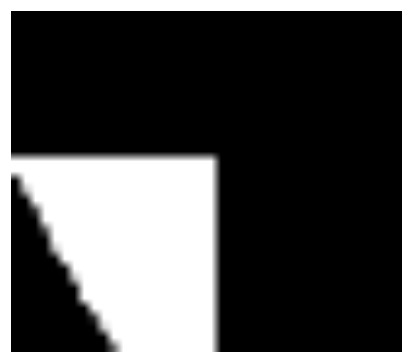

In [114]:
Image.init_from_channels_at_back(rendered_images[375:410,280:320,0]).view(new_figure=True) 

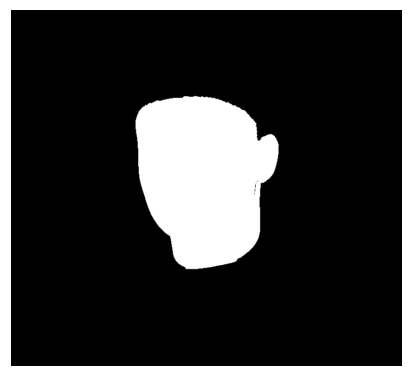

In [48]:
face_mask = np.any(rendered_images > 0, axis=-1)
Image.init_from_channels_at_back(face_mask).view(new_figure=True)    

In [115]:
index_image = np.argmax(rendered_images, axis=-1)
final_masks = deepcopy(rendered_images)
for i in range(rendered_images.shape[-1]):
    final_masks[:,:,i] = np.logical_and(face_mask, index_image==i)

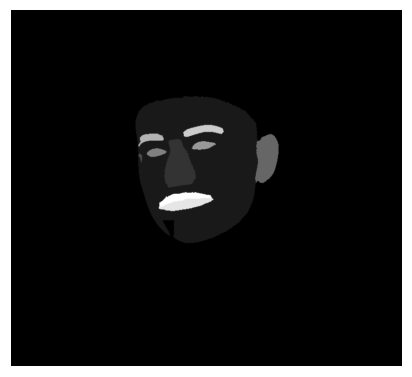

In [116]:
Image.init_from_channels_at_back(index_image).view(new_figure=True)

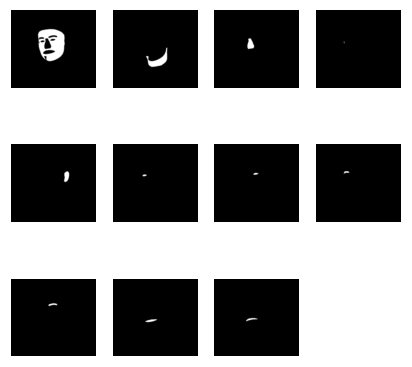

In [51]:
Image.init_from_channels_at_back(final_masks).view(new_figure=True)

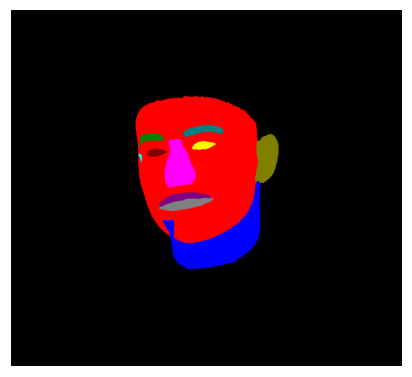

In [106]:
index_image = np.argmax(rendered_images, axis=-1)
final_masks = deepcopy(rendered_images)
color_masks = np.zeros((rendered_images.shape[0],rendered_images.shape[1],3))
for i in range(rendered_images.shape[-1]):
#     if i == 0:
    if True:
        x, y = np.where(index_image==i)    
        final_masks[:,:,i] = np.logical_and(face_mask, index_image==i)
        color_masks[x,y] = colours[i]/255.0
    
face_mask = np.logical_not(np.any(rendered_images, axis=-1))
color_masks[face_mask] = 0
    
Image.init_from_channels_at_back(color_masks).view(new_figure=True) 

In [61]:
# # Render texture
vertex_scaled = deepcopy(vertex_projected.T[:,:2])
# the image coordinate system is a bit different from us.
# the origin of an image is indeed (0, image_height)
vertex_scaled[:, 1] = canvas_height-vertex_scaled[:, 1]
vertex_scaled = vertex_scaled * 2. / [canvas_width, canvas_height] - 1.
tf_vertices = tf.concat([vertex_scaled, tf.zeros([vertex_scaled.shape[0], 1]), tf.ones([vertex_scaled.shape[0], 1])], axis=1)

tf_tri = tf.constant(tri, dtype=tf.int32)

n_channel = 3
bg = tf.zeros((canvas_height, canvas_width, n_channel), dtype=tf.float32)

# use the cropped version
mesh = TriMesh(vertex_scaled, trilist=tri)
new_mesh, _ = delete_trimesh_points(keep_list, mesh)
tf_tri = tf.constant(new_mesh.trilist, dtype=tf.int32)
#
n_vertex = new_mesh.n_points
vertex_scaled = vertex_scaled[keep_list]
tf_vertices = tf.concat([vertex_scaled, tf.zeros([n_vertex, 1]), tf.ones([n_vertex, 1])], axis=1)


xy_in_image = np.round(vertex_projected.T[:,:2]).astype(np.int)
vertex_texture = image[xy_in_image[:,1], xy_in_image[:,0]]
vertex_texture = vertex_texture[keep_list]

rasterise_texture = dirt.rasterise(
                        vertices=tf_vertices,
                        faces=tf_tri,
                        vertex_colors=vertex_texture,
                        background=bg,
                        height=canvas_height, width=canvas_width, channels=n_channel
                    )

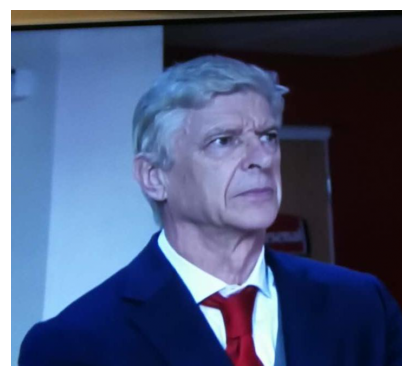

In [62]:
orig_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
orig_image = Image.init_from_channels_at_back(orig_image/255.)
orig_image.view()

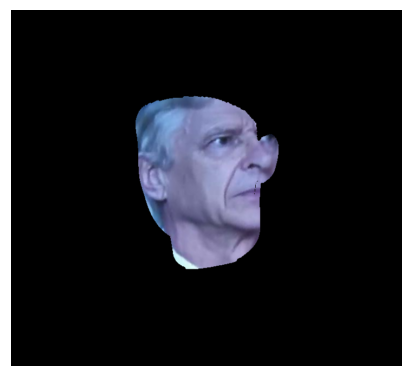

In [63]:
with tf.Session() as sess:    
    rendered_image = sess.run(rasterise_texture)

rendered_image = cv2.cvtColor(rendered_image, cv2.COLOR_BGR2RGB)
texture_image = Image.init_from_channels_at_back(rendered_image/255.)
texture_image.view()